# Introduction

This notebook guides through calibration function development using published data (S. De Vito et al., Sensors and Actuators B: Chemical, Volume 129, Issue 2).

In [2]:
# Load libriaries.
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve, learning_curve
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.decomposition import FastICA, KernelPCA

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.size'] = 6.0
plt.rcParams['axes.titlesize'] = 6.0

# Method(s)
A neural network is used as machine learning algorithm. To avoid overfitting, a randomized grid search over regularization parameter and neural network architecture is performed.

In [3]:
# Define helper functions.
scaler = StandardScaler(copy=True) # Define standard scaler instance.
imputer = SimpleImputer() # Define imputer instance.
detector = IsolationForest(n_estimators=1000, random_state=0) # Define outlier detector instance.
dim_red = KernelPCA(n_components=2, kernel="rbf", random_state=0, n_jobs=-1) # Define dimensionality reduction instance.
model = MLPRegressor(max_iter=10000, random_state=0) # Define neural network model instance.
lin_reg = LinearRegression() # Define linear regression instance.

# Data Handling
Load data to pandas data frame.

In [4]:
# Load data and keep only first six months.
data = pd.read_excel("data.xlsx")
data = data[data["Date"] <= "2004-09-10"]

# Visualize data summary.
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,3447.000000,4275.000000,914.000000,4275.000000,4275.000000,3525.000000,4275.000000,3522.000000,4275.000000,4275.000000,4275.000000,4275.000000,4275.000000
mean,1.918422,1077.334113,218.811816,9.850661,937.848090,126.051348,897.271150,94.706133,1617.936394,944.460370,23.451201,42.485045,1.153040
std,1.206673,200.344215,204.459921,6.566329,240.489984,83.970746,228.686816,36.637686,255.788785,343.175279,7.843419,15.985736,0.343338
min,0.100000,708.000000,7.000000,0.464418,437.000000,2.000000,387.500000,5.000000,955.000000,263.000000,6.100000,9.175000,0.375444
25%,1.000000,932.250000,67.000000,4.843458,755.500000,63.000000,735.875000,67.000000,1441.750000,692.875000,17.300000,29.500000,0.904255
50%,1.700000,1047.500000,150.000000,8.499723,919.500000,108.000000,860.000000,94.000000,1587.000000,896.500000,23.450000,42.500000,1.096318
75%,2.500000,1184.250000,297.000000,13.385657,1096.500000,168.000000,1022.750000,119.000000,1752.625000,1150.625000,28.600000,54.000000,1.366492
max,8.100000,2039.750000,1189.000000,40.260061,1776.250000,631.000000,1940.750000,233.000000,2746.000000,2474.750000,44.600000,85.150002,2.180639


# Preprocessing
The data is preprocessed and sliced into different sets. Data is scaled before analysis. In particular, standard scaling provides better results with respect to R2 score and explained variance.
No imputation is performed.

In [5]:
# Select columns and remove rows with missing values.
columns = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH", "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
data = data[columns].dropna(axis=0)

# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(data)

# Optional: Impute missing values.
# X_t = imputer.fit_transform(X_t)

# Remove outliers.
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]

# Restore frame.
data = pd.DataFrame(X_t, columns=columns)

# First Iteration
In a first iteration, the order of the data is kept, i.e. the performance of the model is analyzed on the second quarter of measuring.

In [6]:
# Define training data.
data_train = data.iloc[0:(7*data.shape[0]//10)]
X = data_train[["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]]
Y = data_train[["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]]

# Define test data.
data_test = data.iloc[(7*data.shape[0]//10):]
X_test = data_test[["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]]
Y_test = data_test[["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]]

print("Training set consists of", X.shape[0], "samples. Test set contains", X_test.shape[0], "samples.")

Training set consists of 1892 samples. Test set contains 811 samples.


# Dimensionality Reduction

This experiments was performed at one place, i.e. the collections of sensors was stationary. Since the concentration of pollutants is cyclic due to night-day cycles, it is expected that the signals are correlated and lie in a subspace which is parametrized by a time variable. This can be examined by performing a dimensionality reduction.

/Library/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


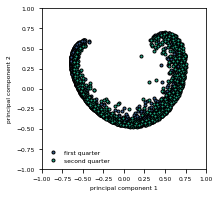

In [45]:
# Perform dimensionality reduction on the data.
Y_r_train = dim_red.fit_transform(Y)
Y_r_test = dim_red.fit_transform(Y_test)

# Plot in reduced dimensions.
fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
plt.plot(Y_r_train[:,0], Y_r_train[:,1], color=plt.cm.viridis(0.3), marker=".", alpha=1.0, mec='k', linestyle="", label="first quarter")
plt.plot(Y_r_test[:,0], Y_r_test[:,1], color=plt.cm.viridis(0.6), marker=".", alpha=1.0, mec='k', linestyle="", label="second quarter")
plt.ylim(-1.0, 1.0)
plt.xlim(-1.0, 1.0)
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.legend(frameon=False, loc=3)
plt.savefig('./figures/dimensionality_reduction',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

A Kolmogorov-Smirnoff test between the first three and the second three months of collections is not able to show any difference in distribution of signal intensities, as all p-values are below 0.05.

In [7]:
# Training phase.
parameters = {"alpha": np.logspace(-2, 2, 50), "hidden_layer_sizes": [(5), (10)]} # Define grid. 
clf1 = RandomizedSearchCV(model, parameters, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=0) # Run grid search.
clf1.fit(X, Y) # Train/optimize regressor.
model1 = clf1.best_estimator_ # Select best model.

# Results and Discussion

The performance is mediocre, and it remains to analyze wheter the sequential aspect (e.g. due to drift) makes the performance worse.

In [8]:
# Evaluate first model in testing phase.
Y_predict = model1.predict(X_test) # Predict.
exp = explained_variance_score(Y_test, Y_predict) 
r2 = r2_score(Y_test, Y_predict)
mse = mean_squared_error(Y_test, Y_predict)
print("Explained variance is", np.round(exp, 2), ", R2 score is", np.round(r2, 2), ", and MSE is", np.round(mse, 2), ".")

Explained variance is 0.75 , R2 score is 0.71 , and MSE is 0.17 .


# Second Iteration
In a second iteration, the order of the data is not kept, i.e. the performance of the model is analyzed on the shuffeled data.

In [9]:
# Reassign training data.
X = data[["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]]
Y = data[["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]]

# Perform slicing into training and test set.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=0)
print("Training set consists of", X_train.shape[0], "samples. Test set contains", X_test.shape[0], "samples.")

Training set consists of 1892 samples. Test set contains 811 samples.


In [10]:
# Training phase.
parameters = {"alpha": np.logspace(-2, 2, 50), "hidden_layer_sizes": [(5), (10)]} # Define grid. 
clf2 = RandomizedSearchCV(model, parameters, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=0) # Run grid search.
clf2.fit(X_train, Y_train) # Train/optimize regressor.
model2 = clf2.best_estimator_ # Select best model.

# Results and Discussion

The model with shuffled data is better with respect to the metrics.

In [12]:
# Evaluate second model in testing phase.
Y_predict = model2.predict(X_test) # Predict.
exp = explained_variance_score(Y_test, Y_predict) 
r2 = r2_score(Y_test, Y_predict)
mse = mean_squared_error(Y_test, Y_predict)
print("Explained variance is", np.round(exp, 2), ", R2 score is", np.round(r2, 2), ", and MSE is", np.round(mse, 2), ".")

Explained variance is 0.83 , R2 score is 0.83 , and MSE is 0.1 .


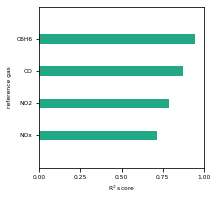

In [13]:
# Compute individual R2 scores.
r2_ = r2_score(Y_test, Y_predict, multioutput="raw_values")
labels = [item[:-4] for item in Y.columns]

# Plot individual R2 scores.
fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
plt.barh(range(len(r2_)), r2_[r2_.argsort()], color=plt.cm.viridis(0.6), ecolor=plt.cm.viridis(0.6), 
         height=0.3, xerr=None, align="center", alpha=1.0)
plt.yticks(range(len(r2_)), np.array(labels)[r2_.argsort()],rotation=0)
plt.xticks((0,0.25,0.5,0.75,1.0))
plt.ylim([-1, len(r2_)])
plt.xlim([0, 1.0])
plt.xlabel("R$^2$ score")
plt.ylabel("reference gas")
plt.savefig('./figures/R2',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

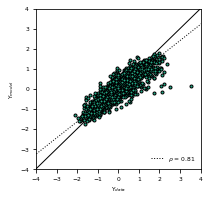

In [13]:
# Determine slope.
slope = lin_reg.fit(Y_test.values.flatten().reshape(-1, 1), Y_predict.flatten().reshape(-1, 1))

# Perform predictions.
Y_syn = np.linspace(-10, 10, 10)
Y_syn_p = slope.predict(Y_syn.reshape(-1, 1))

# Plot predictions vs. true values.
fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Y$_{data}$")
ax.set_ylabel(r"Y$_{model}$")
ax.set_xlim(-4.0, 4.0)
ax.set_ylim(-4.0, 4.0)
ax.plot(Y_syn,Y_syn_p, ":", color="k", label=r"$\rho$ = "+str(np.round(slope.coef_[0][0],2)))
ax.plot([-10,10],[-10,10], "-", color="k")
ax.plot(Y_test.values, Y_predict, color=plt.cm.viridis(0.6), marker=".", alpha=1.0, mec='k', linestyle="")
plt.legend(frameon=False, loc=4)
plt.savefig('./figures/congruency',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

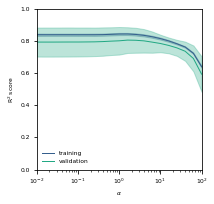

In [16]:
# Compute validation curve.
param_range = np.logspace(-2, 2, 21)
train_scores, test_scores = validation_curve(model2, X, Y, 
                                             "alpha", param_range, cv=10, 
                                             scoring="r2", verbose=0, n_jobs=-1)

# Plot validation curve.
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
ax = fig.add_subplot(111)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("R$^2$ score")
ax.set_ylim(0.0, 1.0)
ax.set_xlim(param_range[0], param_range[-1])
plt.semilogx(param_range, train_scores_mean, label="training",color=plt.cm.viridis(0.3))
plt.fill_between(param_range, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.3,color=plt.cm.viridis(0.3))
plt.semilogx(param_range, test_scores_mean, label="validation",color=plt.cm.viridis(0.6))
plt.fill_between(param_range, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.3,color=plt.cm.viridis(0.6))
plt.legend(frameon=False, loc=3)
plt.savefig('./figures/validation_curve',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

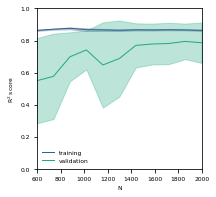

In [22]:
# Compute training curve.
train_sizes, train_scores, test_scores = learning_curve(model2, X, Y, 
                                                        train_sizes=np.linspace(600, 2000, 11, dtype="int"), 
                                                        scoring="r2", cv=10, verbose=0, n_jobs=-1)

# Plot training curve.
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
ax = fig.add_subplot(111)
ax.set_xlabel(r"N")
ax.set_ylabel("R$^2$ score")
ax.set_ylim(0.0, 1.0)
ax.set_xlim(train_sizes[0], train_sizes[-1])
plt.plot(train_sizes, train_scores_mean, label="training",color=plt.cm.viridis(0.3))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.3,color=plt.cm.viridis(0.3))
plt.plot(train_sizes, test_scores_mean, label="validation",color=plt.cm.viridis(0.6))
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.3,color=plt.cm.viridis(0.6))
plt.legend(frameon=False, loc=3)
plt.savefig('./figures/training_curve',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

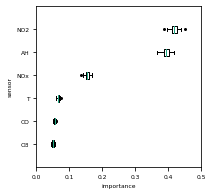

In [17]:
# Compute and plot permutation importance.
importance = permutation_importance(model2, X_train, Y_train, n_repeats=100, scoring="r2", random_state=0) # Compute.
perm_sorted_idx = importance.importances_mean.argsort() # Sort labels.
labels_ = [item.split("(")[-1].split(")")[0] for item in X_test.columns[perm_sorted_idx]] # Customize labels.

fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
bp = plt.boxplot(importance.importances[perm_sorted_idx].T, vert=False, labels=labels_,
           flierprops=dict(markersize=4, markerfacecolor='k',marker='.'), widths=0.3)
plt.setp(bp['medians'], color=plt.cm.viridis(0.6))
plt.xlabel("importance")
plt.ylabel("sensor")
plt.xlim((0,0.5))
plt.ylim((0, 7))
plt.savefig('./figures/permutation_importance',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

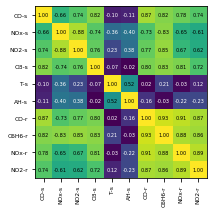

In [19]:
# Calculate and plot covariance matrix.
rho, pval = sp.stats.spearmanr(data.values)
sigma = rho[::-1]

labels = [item[:-4] for item in Y.columns]
labels__ = [item.split("(")[-1].split(")")[0]+"-s" for item in X_test.columns]+[item+"-r" for item in labels]

fig, ax = plt.subplots(figsize=(2.95,2.95))
fig.tight_layout()
im = ax.imshow(np.abs(sigma), cmap=plt.cm.viridis, aspect="equal")

# We want to show all ticks.
ax.set_ylim((0-0.5,len(labels__)-0.5))
ax.set_xticks(np.arange(len(labels__)))
ax.set_yticks(np.arange(len(labels__)))
# ... and label them with the respective list entries
ax.set_xticklabels(labels__)
ax.set_yticklabels(labels__[::-1])

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = sigma.max() / 2.
for i in range(sigma.shape[0]):
    for j in range(sigma.shape[1]):
        ax.text(j, i, format(sigma[i,j], fmt), fontsize=5,ha='center', va='center',color='white' if np.abs(sigma[i,j]) < thresh else 'black')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha='center',rotation_mode='default')

fig.tight_layout()
plt.savefig('./figures/correlations',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

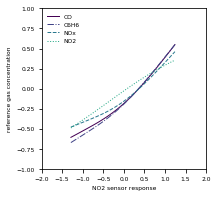

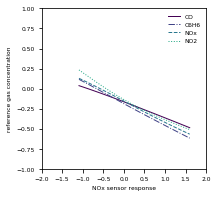

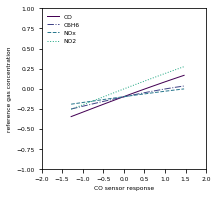

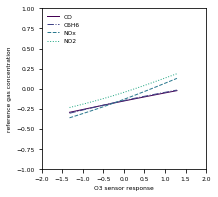

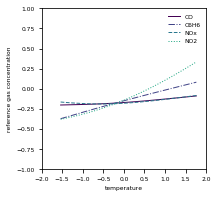

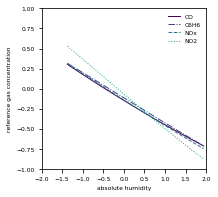

In [20]:
# Compute and plot partial dependences.
linestyles = ["-","-.","--",":"]

# NO2 sensor.
y_, x_ = partial_dependence(model2, X, ["PT08.S4(NO2)"])
fig = plt.figure(figsize=(2.95,2.95))
colors = plt.cm.Wistia(np.linspace(0,1,4))
for k, label in enumerate(Y.columns):
    plt.plot(x_[0],y_[k].ravel(), linestyles[k], color=plt.cm.viridis((k)*1/5), label=label[:-4])
plt.xlabel("NO2 sensor response")
plt.ylabel("reference gas concentration")
plt.legend(loc=2,frameon=False)
plt.xlim((-2.0,2.0))
plt.ylim((-1.0,1.0))
plt.savefig("./figures/pdp_NO2",dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

# NOx sensor.
y_, x_ = partial_dependence(model2, X, ["PT08.S3(NOx)"])
fig = plt.figure(figsize=(2.95,2.95))
colors = plt.cm.Wistia(np.linspace(0,1,4))
for k, label in enumerate(Y.columns):
    plt.plot(x_[0],y_[k].ravel(), linestyles[k], color=plt.cm.viridis((k)*1/5), label=label[:-4])
plt.xlabel("NOx sensor response")
plt.ylabel("reference gas concentration")
plt.legend(loc=1,frameon=False)
plt.xlim((-2.0,2.0))
plt.ylim((-1.0,1.0))
plt.savefig("./figures/pdp_NOx",dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')

# CO sensor.
y_, x_ = partial_dependence(model2, X, ["PT08.S1(CO)"])
fig = plt.figure(figsize=(2.95,2.95))
colors = plt.cm.Wistia(np.linspace(0,1,4))
for k, label in enumerate(Y.columns):
    plt.plot(x_[0],y_[k].ravel(), linestyles[k], color=plt.cm.viridis((k)*1/5), label=label[:-4])
plt.xlabel("CO sensor response")
plt.ylabel("reference gas concentration")
plt.legend(loc=2,frameon=False)
plt.xlim((-2.0,2.0))
plt.ylim((-1.0,1.0))
plt.savefig("./figures/pdp_CO",dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')

# O3 sensor.
y_, x_ = partial_dependence(model2, X, ["PT08.S5(O3)"])
fig = plt.figure(figsize=(2.95,2.95))
colors = plt.cm.Wistia(np.linspace(0,1,4))
for k, label in enumerate(Y.columns):
    plt.plot(x_[0],y_[k].ravel(), linestyles[k], color=plt.cm.viridis((k)*1/5), label=label[:-4])
plt.xlabel("O3 sensor response")
plt.ylabel("reference gas concentration")
plt.legend(loc=2,frameon=False)
plt.xlim((-2.0,2.0))
plt.ylim((-1.0,1.0))
plt.savefig("./figures/pdp_O3",dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')

# Temperature.
y_, x_ = partial_dependence(model2, X, ["T"])
fig = plt.figure(figsize=(2.95,2.95))
colors = plt.cm.Wistia(np.linspace(0,1,4))
for k, label in enumerate(Y.columns):
    plt.plot(x_[0],y_[k].ravel(), linestyles[k], color=plt.cm.viridis((k)*1/5), label=label[:-4])
plt.xlabel("temperature")
plt.ylabel("reference gas concentration")
plt.legend(loc=1,frameon=False)
plt.xlim((-2.0,2.0))
plt.ylim((-1.0,1.0))
plt.savefig("./figures/pdp_T",dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')

# Absolute humidity.
y_, x_ = partial_dependence(model2, X, ["AH"])
fig = plt.figure(figsize=(2.95,2.95))
colors = plt.cm.Wistia(np.linspace(0,1,4))
for k, label in enumerate(Y.columns):
    plt.plot(x_[0],y_[k].ravel(), linestyles[k], color=plt.cm.viridis((k)*1/5), label=label[:-4])
plt.xlabel("absolute humidity")
plt.ylabel("reference gas concentration")
plt.legend(loc=1,frameon=False)
plt.xlim((-2.0,2.0))
plt.ylim((-1.0,1.0))
plt.savefig("./figures/pdp_AH",dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')